# Description

Analyze research backtest results.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os
from typing import Dict, List

import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import dataflow.core as dtfcore
import dataflow.model as dtfmod
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint
import im_v2.common.data.client.historical_pq_clients as imvcdchpcl
import market_data as mdata

/app/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-e3582dd1-b6e3-4df2-918b-f1be9079991b.json'
INFO  # Git
  branch_name='CMTask7425_update_the_model_sweep_notebook'
  hash='b15e6a2f9'
  # Last commits:
    * b15e6a2f9 Daniil Tikhomirov CMTask7425: Checkpoint                                            (23 minutes ago) Mon Mar 4 14:52:24 2024  (HEAD -> CMTask7425_update_the_model_sweep_notebook, origin/CMTask7425_update_the_model_sweep_notebook)
    * f99a70e9a Daniil Tikhomirov CMTask7425: Create a new master notebook                          (32 minutes ago) Mon Mar 4 14:43:03 2024           
    * dfd15fac4 Grigorii Pomazkin Cm task7334 create new universe (#7436)                           (83 minutes ago) Mon Mar 4 13:52:32 2024  (origin/master, origin/HEAD, master)
# Machine info
  system=Linux
  node name=892805e4b287
  release=5.15.0-1053-aws
  version=#58~20.04.1-Ubuntu SMP Mon Jan 22 17:15:01 UTC 2024
  machine=x86_6

# Functions

In [4]:
# TODO(Dan): Move to a lib.
def build_research_backtest_analyzer_config_dict(
    default_config: cconfig.Config,
) -> Dict[str, cconfig.Config]:
    """
    Build a dict of configs to run a backtest analysis.
    """
    if "sweep_param" in default_config:
        hdbg.dassert_isinstance(default_config["sweep_param"], cconfig.Config)
        # Set param values to sweep and corressponding config keys.
        sweep_param_keys = default_config["sweep_param", "keys"]
        hdbg.dassert_isinstance(sweep_param_keys, tuple)
        sweep_param_values = default_config["sweep_param", "values"]
        hdbg.dassert_isinstance(sweep_param_values, list)
        # Build config dict.
        config_dict = {}
        for val in sweep_param_values:
            # Update new config value.
            config = default_config.copy()
            config.update_mode = "overwrite"
            config[sweep_param_keys] = val
            config.update_mode = "assert_on_overwrite"
            # Set updated config key for config dict.
            config_dict_key = ":".join(sweep_param_keys)
            config_dict_key = " = ".join([config_dict_key, str(val)])
            # Add new config to the config dict.
            config_dict[config_dict_key] = config
    else:
        # Put single input config to a dict.
        config_dict = {"default_config": default_config}
    return config_dict

# Build the config dict

In [5]:
# Get config from env when running the notebook via the `run_notebook.py` script.
default_config = cconfig.get_config_from_env()
if default_config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Build default config.
    amp_dir = hgit.get_amp_abs_path()
    dir_name = os.path.join(
        amp_dir,
        "/shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.6T.2023-06-01_2024-01-31.ins.run0/tiled_results",
    )
    default_config_dict = {
        "dir_name": dir_name,
        "start_date": datetime.date(2023, 6, 1),
        "end_date": datetime.date(2024, 1, 31),
        "asset_id_col": "asset_id",
        "pnl_resampling_frequency": "D",
        "rule": "6T",
        "im_client_config": {
            "vendor": "ccxt",
            "universe_version": "v8.1",
            "root_dir": "s3://cryptokaizen-data.preprod/v3",
            "partition_mode": "by_year_month",
            "dataset": "ohlcv",
            "contract_type": "futures",
            "data_snapshot": "",
            "aws_profile": "ck",
            "version": "v1_0_0",
            "download_universe_version": "v8",
            "tag": "downloaded_1min",
            "download_mode": "periodic_daily",
            "downloading_entity": "airflow",
            "resample_1min": False,
        },
        "annotate_forecasts_kwargs": {
            "style": "longitudinal",
            "quantization": 30,
            "liquidate_at_end_of_day": False,
            "initialize_beginning_of_day_trades_to_zero": False,
            "burn_in_bars": 3,
            "compute_extended_stats": True,
            "target_dollar_risk_per_name": 1.0,
            "modulate_using_prediction_magnitude": False,
            "prediction_abs_threshold": 0.3,
        },
        "column_names": {
            "price_col": "open",
            "volatility_col": "garman_klass_vol",
            "prediction_col": "feature",
        },
        "bin_annotated_portfolio_df_kwargs": {
            "proportion_of_data_per_bin": 0.2,
            "normalize_prediction_col_values": False,
        },
        "load_all_tiles_in_memory": True,
        "sweep_param": {
            "keys": (
                "column_names",
                "price_col",
            ),
            "values": [
                "open",
            ],
        },
    }
    default_config = cconfig.Config().from_dict(default_config_dict)
print(default_config)

INFO  Using hardwired config
dir_name: /shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.6T.2023-06-01_2024-01-31.ins.run0/tiled_results
start_date: 2023-06-01
end_date: 2024-01-31
asset_id_col: asset_id
pnl_resampling_frequency: D
rule: 6T
im_client_config: 
  vendor: ccxt
  universe_version: v8.1
  root_dir: s3://cryptokaizen-data.preprod/v3
  partition_mode: by_year_month
  dataset: ohlcv
  contract_type: futures
  data_snapshot: 
  aws_profile: ck
  version: v1_0_0
  download_universe_version: v8
  tag: downloaded_1min
  download_mode: periodic_daily
  downloading_entity: airflow
  resample_1min: False
annotate_forecasts_kwargs: 
  style: longitudinal
  quantization: 30
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  burn_in_bars: 3
  compute_extended_stats: True
  target_dollar_risk_per_name: 1.0
  modulate_using_prediction_magnitude: False
  prediction_abs_threshold: 0.3
column_names: 
  price_col: open
  volatility_col: garm

# Load tiled results

## Report tile stats

In [6]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    default_config["dir_name"]
)

In [7]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1020313424,2,8,8,40.9 MB
1106736216,2,8,8,41.0 MB
1669260535,2,8,8,41.3 MB
1670436375,2,8,8,40.9 MB
1775391824,2,8,8,40.7 MB
1813442534,2,8,8,41.3 MB
1871387621,2,8,8,40.6 MB
2200033667,2,8,8,40.4 MB
2237530510,2,8,8,40.6 MB


In [8]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids      size
year month                       
2023 6               23  114.6 MB
     7               25  120.1 MB
     8               25  128.8 MB
     9               25  124.7 MB
     10              25  129.1 MB
     11              25  125.1 MB
     12              25  129.6 MB
2024 1               25  129.5 MB

In [9]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1020313424,
 1106736216,
 1669260535,
 1670436375,
 1775391824,
 1813442534,
 1871387621,
 2200033667,
 2237530510,
 2470395105,
 2499295598,
 2506553600,
 2565005155,
 2601760471,
 2971863517,
 2989693852,
 3304664847,
 3323452427,
 3326458212,
 4417972573,
 5141755262,
 6009830573,
 6335759645,
 8717633868,
 8968126878]

## Load tile data

In [10]:
if default_config["load_all_tiles_in_memory"]:
    asset_ids_to_load = asset_ids
else:
    asset_ids_to_load = asset_ids[0:1]
asset_batch_size = len(asset_ids_to_load)
cols = None
#
asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        default_config["dir_name"],
        asset_ids_to_load,
        default_config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# Trim tile to the specified time interval.
asset_tile = asset_tile[
    (asset_tile.index >= pd.Timestamp(default_config["start_date"], tz="UTC"))
    & (asset_tile.index <= pd.Timestamp(default_config["end_date"], tz="UTC"))
]
len(asset_tile)

1437478

In [12]:
tile_df = dtfmod.process_parquet_read_df(
    asset_tile, default_config["asset_id_col"]
)

In [13]:
tile_df.columns.levels[0].to_list()

['close',
 'close_mean',
 'feature',
 'garman_klass_vol',
 'high',
 'low',
 'month',
 'open',
 'p1',
 'p1.c',
 'p1.c.xs_adj',
 'p1.c.xs_adj.c',
 'p2',
 'p2.c',
 'p2.c.xs_adj',
 'p2.c.xs_adj.c',
 'p3',
 'p_diff',
 'p_diff.c',
 'p_diff.c.xs_adj',
 'p_diff.c.xs_adj.c',
 'p_est_mean',
 'p_lr',
 'p_lr.c',
 'p_lr.c.xs_adj',
 'p_lr.c.xs_adj.c',
 'q1',
 'q1.c',
 'q1.c.xs_adj',
 'q1.c.xs_adj.c',
 'q2',
 'q2.c',
 'q2.c.xs_adj',
 'q2.c.xs_adj.c',
 'q3',
 'q3.c',
 'q3.c.xs_adj',
 'q3.c.xs_adj.c',
 'q4',
 'q5',
 'q6',
 'q_mv',
 'q_mv_adj',
 'q_mv_os',
 'r1',
 'r1.c',
 'r1.c.xs_adj',
 'r1.c.xs_adj.c',
 'r2',
 'r2.c',
 'r2.c.xs_adj',
 'r2.c.xs_adj.c',
 'r3',
 'r4',
 'r4.c',
 'r4.c.xs_adj',
 'r4.c.xs_adj.c',
 'r5',
 'r5.c',
 'r5.c.xs_adj',
 'r5.c.xs_adj.c',
 'r6',
 'r6.c',
 'r6.c.xs_adj',
 'r6.c.xs_adj.c',
 'r_est',
 'r_est.c',
 'r_est.c.xs_adj',
 'r_est.c.xs_adj.c',
 'r_lr',
 'r_lr.c',
 'r_lr.c.xs_adj',
 'r_lr.c.xs_adj.c',
 'sqrt_q_mv',
 'sqrt_q_mv_adj',
 'sqrt_q_mv_os',
 'v_ld',
 'v_ld.c',
 'v_ld.c.

In [14]:
tile_df.head(3)

close                                                                                                                                                                                                                                                                         close_mean                                                                                                                                                                                                                                                                                feature                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                           \
asset_id                  1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534  1871387621 2200033667 2237530510  2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852  3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868  8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878       1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2023-06-01 00:00:00+00:00     1.3821     0.7277     2.5205      9.980     0.5390    0.13322      634.8      11.46     20.809     145.86     0.0846      7.252     0.5997      6.475      1.232        NaN     113.20     18.006     0.9739     2.0910     1.1599        NaN      4.676     14.099     306.90   1.383217   0.727617   2.522867   9.983000   0.539467   0.133135  634.833333  11.458333  20.812167  145.970000   0.084567   7.252833   0.599850   6.476000   1.233000        NaN  113.186667  18.002333   0.973950   2.089917   1.160617        NaN   4.674667  14.106500  306.921667   0.493161   0.801897   1.100688   0.468634   0.379328  -1.021384   0.817968   1.527676  -0.369468   0.362470   0.899875  -0.797428   0.072698  -1.300463  -1.121546        NaN  -1.587029  -1.537099   0.675034  -0.771554   0.912549        NaN  -0.786638   1.273821  -0.456692         0.001584   0.001772   0.001977   0.000730   0.001537   0.001805   0.000521   0.001234   0.000847   0.001484   0.002399   0.001522   
2023-06-01 00:06:00+00:00     1.3794     0.7251

## Add weighted resampling price column

In [15]:
im_client = imvcdchpcl.HistoricalPqByCurrencyPairTileClient(
    **default_config["im_client_config"]
)
columns = None
columns_remap = None
wall_clock_time = pd.Timestamp("2100-01-01T00:00:00+00:00")
market_data = mdata.get_HistoricalImClientMarketData_example1(
    im_client,
    asset_ids,
    columns,
    columns_remap,
    wall_clock_time=wall_clock_time,
)
#
bar_duration = "1T"
ohlcv_data = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    pd.Timestamp(default_config["start_date"], tz="UTC"),
    pd.Timestamp(default_config["end_date"], tz="UTC"),
    bar_duration,
)
ohlcv_data.index = ohlcv_data.index.tz_convert("UTC")
ohlcv_data.index.freq = pd.infer_freq(ohlcv_data.index)
ohlcv_data.head(10)

INFO  fit_intervals=[(Timestamp('2023-06-01 00:00:00+0000', tz='UTC'), Timestamp('2024-01-31 00:00:00+0000', tz='UTC'))]


close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2023-06-01 00:00:00+00:00     1.3812     0.7270     2.5180      9.974     0.5388    0.13324      634.6      11.43     20.795     145.69     0.0846      7.223     0.5995      6.471      1.230        NaN     113.06     17.992     0.9726     2.0886     1.1593        NaN      4.666     14.086     306.80     1.3834     0.7290     2.5235      9.993     0.5397    0.13349      635.9      11.47     20.823     145.87     0.0847      7.251     0.6005      6.478      1.233        NaN     113.23     18.010     0.9750     2.0926     1.1606        NaN      4.679     14.107     307.22     1.3799     0.7269     2.5180      9.974     0.5387    0.13322      634.6      11.43     20.791     145.69     0.0845      7.222     0.5995      6.469      1.230        NaN     113.06     17.991     0.9720     2.0884     1.1586        NaN      4.666     14.086     306.80     1.3821     0.7277     2.5206      9.980     0.5391    0.13322      634.8      11.46     20.810     145.86     0.0846      7.251     0.5998   
2023-06-01 00:01:00+00:00     1.3808     0.

In [16]:
_LOG.info("start_date=%s", default_config["start_date"])
_LOG.info("end_date=%s", default_config["end_date"])
_LOG.info("ohlcv_data min index=%s", ohlcv_data.index.min())
_LOG.info("ohlcv_data max index=%s", ohlcv_data.index.max())
_LOG.info("tile_df min index=%s", tile_df.index.min())
_LOG.info("tile_df max index=%s", tile_df.index.max())

INFO  start_date=2023-06-01
INFO  end_date=2024-01-31
INFO  ohlcv_data min index=2023-06-01 00:00:00+00:00
INFO  ohlcv_data max index=2024-01-31 00:00:00+00:00
INFO  tile_df min index=2023-06-01 00:00:00+00:00
INFO  tile_df max index=2024-01-31 00:00:00+00:00


In [17]:
def resample_with_weights_ohlcv_bars(
    df_ohlcv: pd.DataFrame,
    price_col: str,
    bar_duration: str,
    weights: List[float],
) -> pd.DataFrame:
    """
    Resample 1-minute data to `bar_duration` with weights.
    """
    resampling_node = dtfcore.GroupedColDfToDfTransformer(
        "resample",
        transformer_func=cofinanc.resample_with_weights,
        **{
            "in_col_groups": [
                (price_col,),
            ],
            "out_col_group": (),
            "transformer_kwargs": {
                "rule": bar_duration,
                "col": price_col,
                "weights": weights,
            },
            "reindex_like_input": False,
            "join_output_with_input": False,
        },
    )
    resampled_ohlcv = resampling_node.fit(df_ohlcv)["df_out"]
    return resampled_ohlcv

In [18]:
rule = default_config["rule"]
rule_n_minutes = int(pd.Timedelta(rule).total_seconds() / 60)
rule_n_minutes

6

In [19]:
weights_dict = {
    "first_min_past": [0.0] * 1 + [1.0] + [0.0] * (rule_n_minutes - 2),
    "second_min_past": [0.0] * 2 + [1.0] + [0.0] * (rule_n_minutes - 3),
    "third_min_past": [0.0] * 3 + [1.0] + [0.0] * (rule_n_minutes - 4),
}

In [20]:
for weight_rule, weights in weights_dict.items():
    #
    resampled_price_col = resample_with_weights_ohlcv_bars(
        ohlcv_data,
        default_config["column_names", "price_col"],
        rule,
        weights,
    )
    # Rename the resampled price column.
    res_price_col = "_".join(
        ["resampled", weight_rule, default_config["column_names", "price_col"]]
    )
    resampled_price_col.columns = resampled_price_col.columns.set_levels(
        [res_price_col], level=0
    )
    # Extend sweep param config values.
    default_config["sweep_param"]["values"].append(res_price_col)
    # Append new column to data.
    tile_df = pd.concat([tile_df, resampled_price_col], axis=1)
tile_df.head()

close                                                                                                                                                                                                                                                                         close_mean                                                                                                                                                                                                                                                                                feature                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                           \
                          1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534  1871387621 2200033667 2237530510  2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852  3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868  8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878       1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2023-06-01 00:00:00+00:00     1.3821     0.7277     2.5205      9.980     0.5390    0.13322      634.8      11.46     20.809     145.86     0.0846      7.252     0.5997      6.475      1.232        NaN     113.20     18.006     0.9739     2.0910     1.1599        NaN      4.676     14.099     306.90   1.383217   0.727617   2.522867   9.983000   0.539467   0.133135  634.833333  11.458333  20.812167  145.970000   0.084567   7.252833   0.599850   6.476000   1.233000        NaN  113.186667  18.002333   0.973950   2.089917   1.160617        NaN   4.674667  14.106500  306.921667   0.493161   0.801897   1.100688   0.468634   0.379328  -1.021384   0.817968   1.527676  -0.369468   0.362470   0.899875  -0.797428   0.072698  -1.300463  -1.121546        NaN  -1.587029  -1.537099   0.675034  -0.771554   0.912549        NaN  -0.786638   1.273821  -0.456692         0.001584   0.001772   0.001977   0.000730   0.001537   0.001805   0.000521   0.001234   0.000847   0.001484   0.002399   0.001522   
2023-06-01 00:06:00+00:00     1.3794     0.7251

# Compute portfolio bar metrics

In [21]:
config_dict = build_research_backtest_analyzer_config_dict(default_config)
print(config_dict.keys())

dict_keys(['column_names:price_col = open', 'column_names:price_col = resampled_first_min_past_open', 'column_names:price_col = resampled_second_min_past_open', 'column_names:price_col = resampled_third_min_past_open'])


In [22]:
portfolio_df_dict = {}
bar_metrics_dict = {}
for key, config in config_dict.items():
    if config["load_all_tiles_in_memory"]:
        fep = dtfmod.ForecastEvaluatorFromPrices(
            **config["column_names"].to_dict()
        )
        portfolio_df, bar_metrics = fep.annotate_forecasts(
            tile_df,
            **config["annotate_forecasts_kwargs"].to_dict(),
        )
    else:
        portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
            config["dir_name"],
            config["start_date"],
            config["end_date"],
            config["asset_id_col"],
            config["column_names"]["price_col"],
            config["column_names"]["volatility_col"],
            config["column_names"]["prediction_col"],
            asset_ids=None,
            annotate_forecasts_kwargs=config[
                "annotate_forecasts_kwargs"
            ].to_dict(),
            return_portfolio_df=True,
        )
    portfolio_df_dict[key] = portfolio_df
    bar_metrics_dict[key] = bar_metrics
portfolio_stats_df = pd.concat(bar_metrics_dict, axis=1)

INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  spread is `None`; imputing spread_lower_bound=0.000100


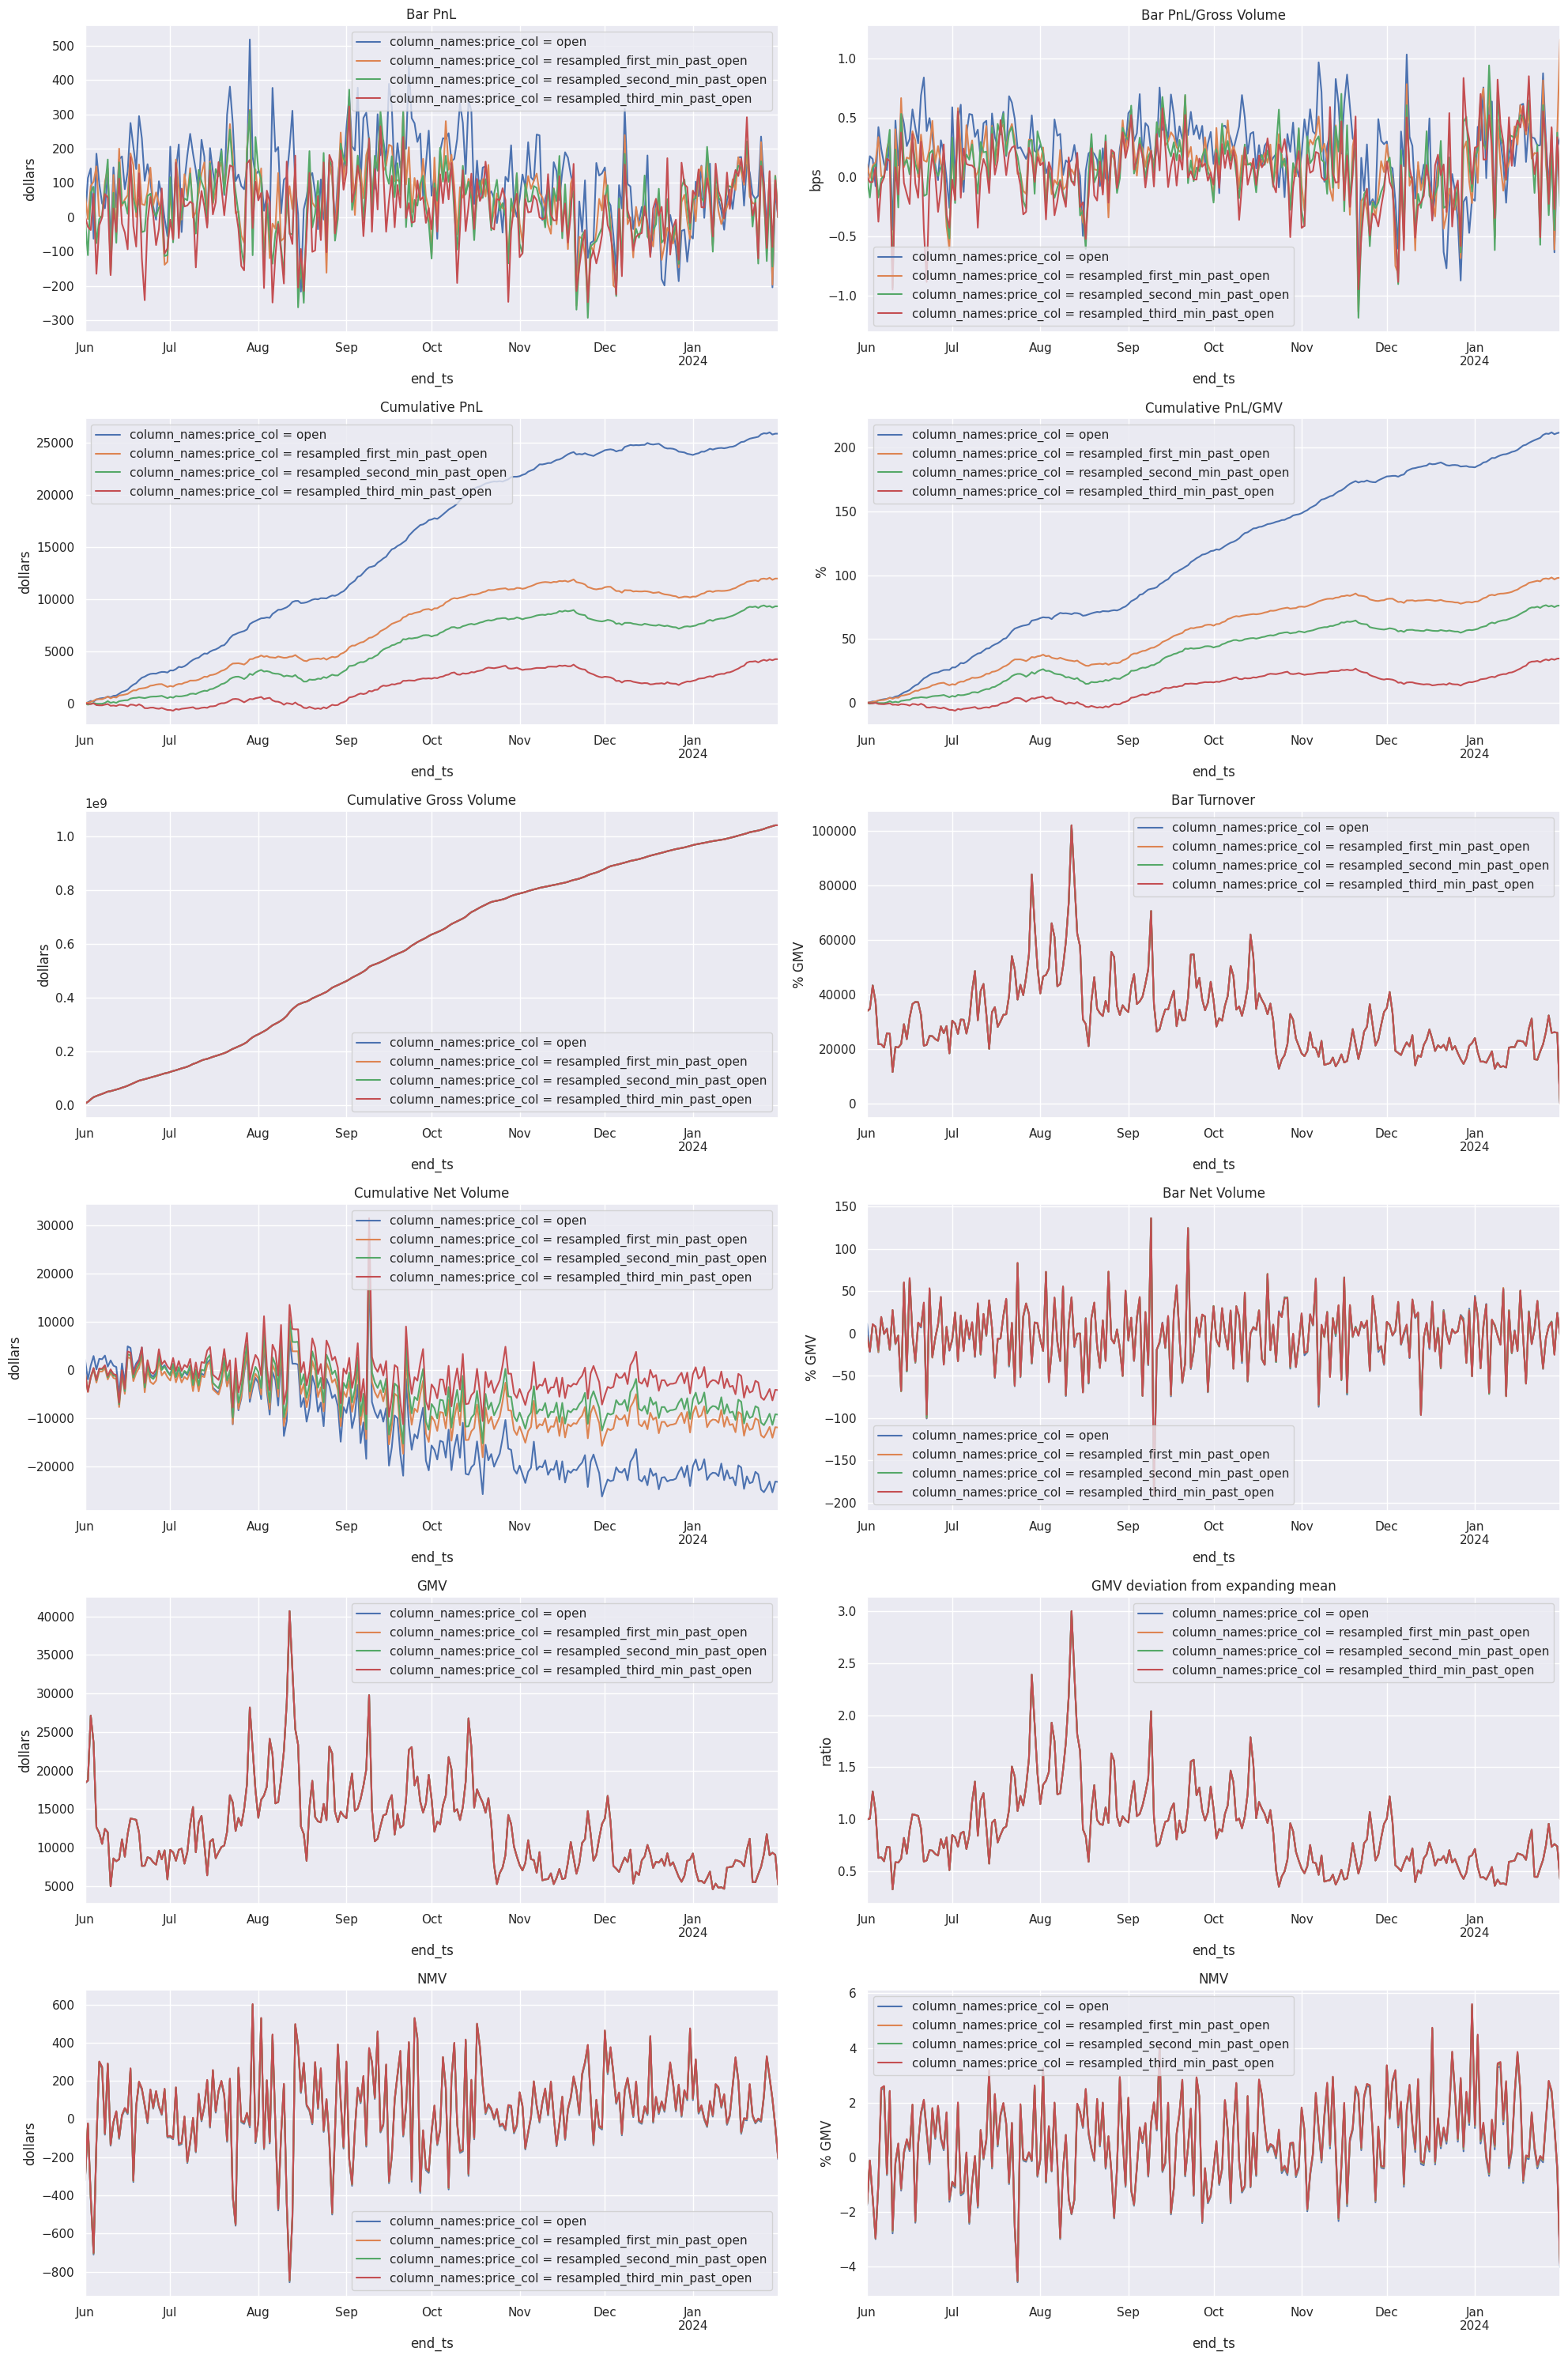

In [23]:
coplotti.plot_portfolio_stats(
    portfolio_stats_df, freq=default_config["pnl_resampling_frequency"]
)

column_names:price_col = open                                column_names:price_col = resampled_first_min_past_open                                column_names:price_col = resampled_second_min_past_open                                column_names:price_col = resampled_third_min_past_open                               
                                           pnl pnl_in_bps  sgn_corr      corr                                                    pnl pnl_in_bps  sgn_corr      corr                                                     pnl pnl_in_bps  sgn_corr      corr                                                    pnl pnl_in_bps  sgn_corr      corr
prediction                                                                                                                                                                                                                                                                                                                                      
(-inf, -0.842]                        0.040417   0.505423  0.020666  0.032572                                           0.017047       0.178886  0.009493  0.013650                                           0.013812        0.104645  0.005919  0.010902                                           0.005949      -0.007759  0.002594  0.004580
(-0.842, -0.253]                      0.016449  -0.000870  0.000797  0.012919                                           0.007087      -0.077754  0.000240  0.005576                                           0.006759       -0.031107 -0.002066  0.005266                                           0.002740      -0.079671 -0.001546  0.002144
(-0.253, 0.253]                       0.000000   0.000000  0.000000  0.000000                                           0.000000       0.000000  0.000000  0.000000                                           0.000000        0.000000  0.000000  0.000000                                           0.000000       0.000000  0.000000  0.000000
(0.253, 0.842]                        0.018352   0.458828  0.018227  0.014391                                           0.008362       0.333016  0.011165  0.006088                                           0.004221        0.266403  0.009874  0.002813                                           0.001959       0.228933  0.008762  0.001307
(0.842, inf]                          0.030905   0.490962  0.018092  0.024745                                           0.017722       0.323346  0.008719  0.014339                                           0.014786        0.355622  0.008762  0.011844                                           0.007967       0.244771  0.004433  0.006226

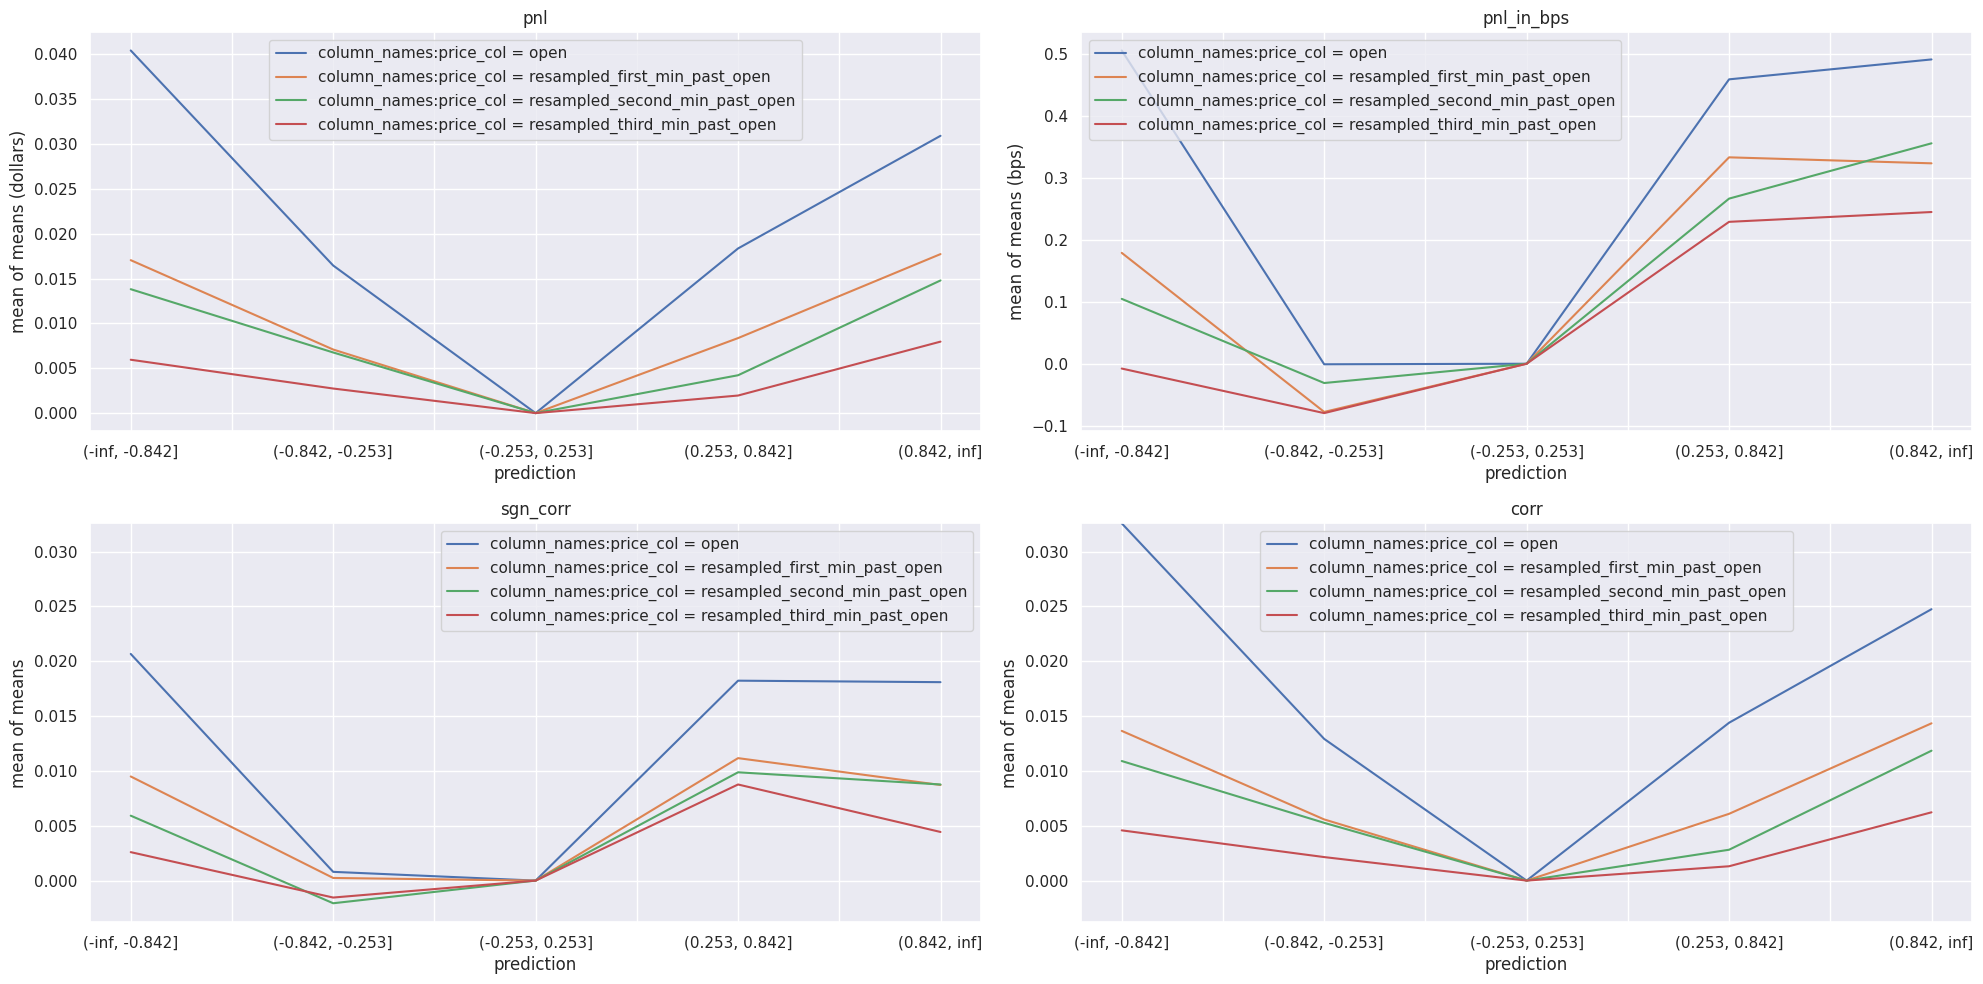

In [24]:
coplotti.plot_portfolio_binned_stats(
    portfolio_df_dict,
    **config["bin_annotated_portfolio_df_kwargs"],
)

# Compute aggregate portfolio stats

In [25]:
stats_computer = dtfmod.StatsComputer()

In [26]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    portfolio_stats_df,
    default_config["pnl_resampling_frequency"],
)
display(portfolio_stats)

column_names:price_col = open  column_names:price_col = resampled_first_min_past_open  column_names:price_col = resampled_second_min_past_open  column_names:price_col = resampled_third_min_past_open
ratios     sharpe_ratio                                         16.60                                               8.87                                                    6.71                                                     3.18     
           sharpe_ratio_standard_error                           1.44                                               1.29                                                    1.26                                                     1.23     
           sr.tval                                              13.60                                               7.27                                                    5.50                                                     2.60     
           sr.pval                                               0.00                                               0.00                                                    0.00                                                     0.01     
           kratio                                                5.21                                               3.30                                                    3.29                                                     1.96     
dollar     gmv_mean                                          12216.02                                           12216.01                                                12216.01                                                 12215.90     
           gmv_stdev                                          5689.91                                            5690.28                                                 5690.20                                                  5690.22     
           annualized_mean_return                            38598.44                                           17871.55                                                13899.79                                                  6338.87     
           annualized_volatility                              2325.17                                            2014.14                                                 2071.70                                                  1995.38     
           max_drawdown                                       1148.13                                            1757.48                                                 1788.65                                                  1960.50     
           pnl_mean                                            105.68                                              48.93                                                   38.06                                                    17.35     
           pnl_std                                             121.66                                             105.39                                                  108.40                                                   104.41     
           turnover_mean                                   4253078.62                                         4252932.21                                              4252913.14                                               4252887.34     
           turnover_stdev                                  1963344.28                                         1963338.96                                              1963334.29                                               1963329.36     
           market_bias_mean                                     46.81                                              51.83                                                   53.60                                                    55.38     
           market_bias_stdev                                   215.07                                             215.05                                                  215.05                                        